## 3 - Data Cleaning

##### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da     #scalable parallel computing
import json
import warnings
import ast

##### Data Loading

In [3]:
# Load ddfs into dictionary (exception for 'all_surf_pos', df)
root_dir = './aggregated_data'
def load_data(root_dir, exception=True):    # Get csv file reads into one dictionary
    data = {}
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            file_name = os.path.splitext(file)[0]   #file name without '.csv'
            if file.endswith('.csv') and file != 'all_surf_positions_HiDrive_Studie2.csv':
                data[file_name] = dd.read_csv(file_path)    #read and attach to dict
            elif exception and file == 'all_surf_positions_HiDrive_Studie2.csv':
                data [file_name] = pd.read_csv(file_path, converters=converters)    #read as normal and attach to dict
    return data
def parse(filedata): # Manually read the column
    output = []
    for line in filedata.split('\n'): # split into lines
        line = line.strip().rstrip(']').lstrip('[') #remove whitespace and brackets
        if not line:  
            continue    #skip empty lines
        line = line.split() #split into cell
        row = []
        for cell in line:
            cell = cell.strip()     #remove whitespace
            if not cell.strip():
                continue    #skip empty cells
            row.append(float(cell)) #convert to float and add
        output.append(row)
    return output
converters = {
    "img_to_surf_trans": parse,
    "surf_to_img_trans": parse,
    "dist_img_to_surf_trans": parse,
    "surf_to_dist_img_trans": parse,
}

data = load_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [ ]:
# Pupil data
columns = ['participant_id', 'pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'diameter_3d', 'model_confidence']
pupil_ddf = data['all_pupil_positions'].loc[:, columns].dropna()

In [ ]:
# Blink data
blink_ddf = data['all_blinks'].iloc[:, 1:]

In [ ]:
# Gaze data
gaze_ddf = data['all_gaze_positions'].iloc[:, 1:]

In [20]:
# Fixation data
fix_ddf = data['all_fixations'].iloc[:, 1:]

In [ ]:
# Surface gaze data
surf_gaze_ddf = data['all_gaze_positions_on_surface_HiDrive_Studie2'].iloc[:, 1:]

In [4]:
# Surface fixation data
surf_fix_ddf = data['all_fixations_on_surface_HiDrive_Studie2'].iloc[:, 1:]
surf_fix_df = surf_fix_ddf.compute()
surf_fix_df = surf_fix_df.groupby(['participant_id', 'fixation_id']).agg({
    'world_timestamp': 'first',
    'start_timestamp': 'first',
    'duration': 'first',
    'dispersion': 'first',
    'norm_pos_x': 'first',
    'norm_pos_y': 'first',
    'x_scaled': 'first',
    'y_scaled': 'first',
    'on_surf': 'first',
    'world_index': lambda x: list(x)  # Aggregate world_index into a list
}).reset_index()

# Rename the aggregated world_index column to world_indexes
surf_fix_df = surf_fix_df.rename(columns={'world_index': 'world_indexes'})
surf_fix_ddf = dd.from_pandas(surf_fix_df, npartitions=2)

In [ ]:
# Surface position data
surf_pos_df = data['all_surf_positions_HiDrive_Studie2'].iloc[:, 1:]

### 1. Plan

##### Pupil
- Diameter_3d based on PupilLabs' physiological bounds: [1.0, 9.0] mm --> data loss ~.4%   (P08, P12 and P15 have higher losses ~1-2%)
- NO low-confidence filtering --> blinks

In [25]:
# Total data loss
pupil_ddf = pupil_ddf[['participant_id', 'diameter_3d']]
filtered_pupil_ddf = pupil_ddf[(pupil_ddf['diameter_3d'] >= 1.0) & (pupil_ddf['diameter_3d'] <= 9.0)]
total_length = pupil_ddf.shape[0].compute()
filtered_length = filtered_pupil_ddf.shape[0].compute()
relative_loss = filtered_length / total_length

print(f"Total length: {total_length}")
print(f"Filtered length: {filtered_length}")
print(f"Relative loss: {1-relative_loss}")

Total length: 15950580
Filtered length: 15882916
Relative loss: 0.004242102795008029


In [26]:
# Participants' data loss
loss_details = {'tot': [], 'filt': [], 'rel': []}
for pid in participant_ids:
    p_pupil_ddf = pupil_ddf[pupil_ddf['participant_id'] == pid]
    p_filtered_pupil_ddf = filtered_pupil_ddf[filtered_pupil_ddf['participant_id'] == pid]

    total_len = p_pupil_ddf.shape[0].compute()
    filtered_len = p_filtered_pupil_ddf.shape[0].compute()

    loss_details['tot'].append(total_len)
    loss_details['filt'].append(filtered_len)
    loss_details['rel'].append(1- (filtered_len/total_len))

loss_details_df = pd.DataFrame(loss_details, index=participant_ids)
print(loss_details_df)

        tot    filt       rel
1   1000352  999763  0.000589
2    758056  754849  0.004231
4    762752  759583  0.004155
5    913029  910378  0.002904
6    805977  805269  0.000878
7    790892  787003  0.004917
8    793690  784676  0.011357
9    803342  802430  0.001135
10   816094  813565  0.003099
11   801449  800992  0.000570
12   801745  792195  0.011912
13   907833  906996  0.000922
14   857561  856108  0.001694
15   814825  798977  0.019450
16   928474  919657  0.009496
17   801299  801133  0.000207
18   890180  887831  0.002639
19   834038  833535  0.000603
20   868992  867976  0.001169


##### Blink
- Blink duration/confidence threshold --> (check data loss)
- *(later) Long blink splitting

In [4]:
# Confidence-duration correlation
blink_ddf = blink_ddf[['participant_id', 'confidence', 'duration']]
plt.figure(figsize=(8, 4))
plt.scatter(blink_ddf['confidence'], blink_ddf['duration'], s =10, alpha=.2)
plt.title(f'Correlation btw blink confidence and duration')
plt.xlabel('confidence level')
plt.ylabel('blink duration')
plt.xlim(0,1)
plt.ylim(-2,70)
plt.show()

NameError: name 'blink_ddf' is not defined

In [15]:
# Total data loss (conf>.05 & dur<2)
# filtered_blink_ddf = blink_ddf[blink_ddf['confidence'] >= 0.05]
# filtered_blink_ddf = blink_ddf[blink_ddf['duration'] <= 5.0]
filtered_blink_ddf = blink_ddf[(blink_ddf['confidence'] >= .05) & (blink_ddf['duration'] <= 2.0)]
total_length = blink_ddf.shape[0].compute()
filtered_length = filtered_blink_ddf.shape[0].compute()
relative_loss = filtered_length / total_length

print(f"Total length:    {total_length}")
print(f"Filtered length: {filtered_length}")
print(f"Relative loss:   {1-relative_loss}")

Total length:    8738
Filtered length: 8318
Relative loss:   0.04806591897459378


In [50]:
# Participants' data loss
loss_details = {'tot': [], 'filt': [], 'rel': []}
for pid in participant_ids:
    p_blink_ddf = blink_ddf[blink_ddf['participant_id'] == pid]
    p_filtered_blink_ddf = filtered_blink_ddf[filtered_blink_ddf['participant_id'] == pid]

    total_len = p_blink_ddf.shape[0].compute()
    filtered_len = p_filtered_blink_ddf.shape[0].compute()

    loss_details['tot'].append(total_len)
    loss_details['filt'].append(filtered_len)
    loss_details['rel'].append(1- (filtered_len/total_len))

loss_details_df = pd.DataFrame(loss_details, index=participant_ids)
print(loss_details_df)

     tot  filt       rel
1    464   458  0.012931
2    605   580  0.041322
4   1065  1036  0.027230
5   1066  1057  0.008443
6    303   301  0.006601
7    225   193  0.142222
8    368   224  0.391304
9    511   502  0.017613
10   503   468  0.069583
11   300   298  0.006667
12   449   440  0.020045
13   318   308  0.031447
14   393   387  0.015267
15   609   546  0.103448
16   271   256  0.055351
17    97    95  0.020619
18   416   411  0.012019
19   328   317  0.033537
20   447   441  0.013423


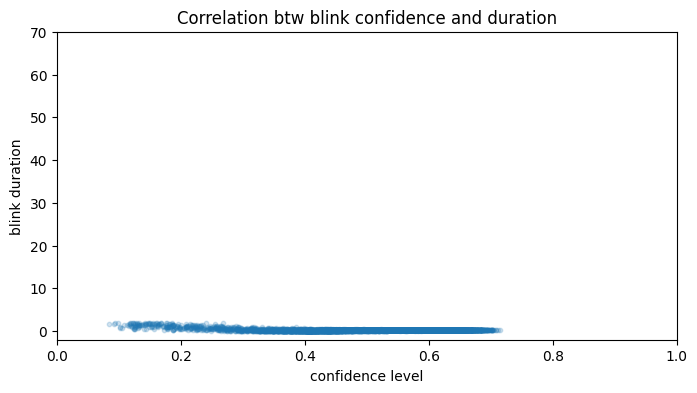

In [24]:
# Confidence-duration correlation
filtered_blink_ddf = filtered_blink_ddf[['participant_id', 'confidence', 'duration']]
plt.figure(figsize=(8, 4))
plt.scatter(filtered_blink_ddf['confidence'], filtered_blink_ddf['duration'], s =10, alpha=.2)
plt.title(f'Correlation btw blink confidence and duration')
plt.xlabel('confidence level')
plt.ylabel('blink duration')
plt.xlim(0,1)
plt.ylim(-2,70)
plt.show()

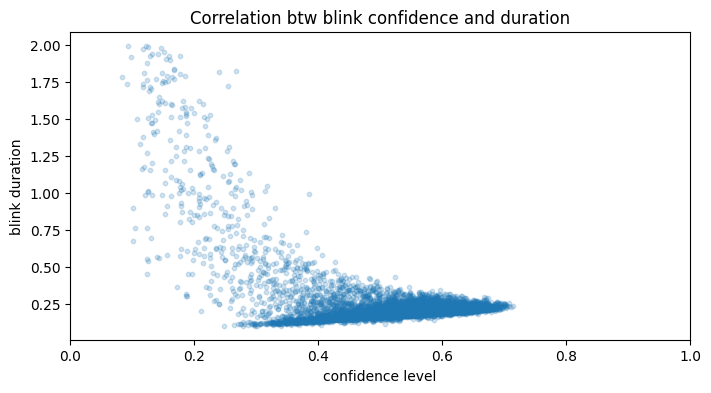

In [23]:
# Confidence-duration correlation
filtered_blink_ddf = filtered_blink_ddf[['participant_id', 'confidence', 'duration']]
plt.figure(figsize=(8, 4))
plt.scatter(filtered_blink_ddf['confidence'], filtered_blink_ddf['duration'], s =10, alpha=.2)
plt.title(f'Correlation btw blink confidence and duration')
plt.xlabel('confidence level')
plt.ylabel('blink duration')
plt.xlim(0,1)
# plt.ylim(-2,70)
plt.show()

##### Gaze
- NO confidence filtering --> derives from pupil
- (position filtering on surface data)

##### Fixation
- Set duration to 220 ms for values slightly exceeding (1e-10) --> 81 values
- longer ones --> reset within 250ms (2) and discard others (6)
- NO confidence filtering --> derived from gaze
- (position filtering on surface data)

In [81]:
long_fix = fix_ddf[fix_ddf['duration'] > 220.1]['duration']
long_fix_diff = [(fix - 220) for fix in long_fix]
print(len(long_fix_diff))
long_fix_diff

8


[22.9550000233576,
 48.01400000022119,
 168.7624999988475,
 10.740000000878354,
 73.99000000012165,
 55.91200001188554,
 98.3130000106757,
 45.07399999536574]

##### Surface Gaze
- Positions within -.5 and 1.5 (.5 margins) --> data loss ~2%   (P13 and P19 have higher losses ~5-7%)
- NO confidence filtering --> derived from gaze
- *(later) P11 position adjustment

In [85]:
# Total data loss
surf_gaze_ddf = surf_gaze_ddf[['participant_id', 'x_norm', 'y_norm']]
filtered_surf_gaze_ddf = surf_gaze_ddf[(surf_gaze_ddf['x_norm'] >= -.5) & (surf_gaze_ddf['x_norm'] <= 1.5) & (surf_gaze_ddf['y_norm'] >= -.5) & (surf_gaze_ddf['y_norm'] <= 1.5)]
total_length = surf_gaze_ddf.shape[0].compute()
filtered_length = filtered_surf_gaze_ddf.shape[0].compute()
relative_loss = filtered_length / total_length

print(f"Total length: {total_length}")
print(f"Filtered length: {filtered_length}")
print(f"Relative loss: {1-relative_loss}")

Total length: 15811255
Filtered length: 15464249
Relative loss: 0.021946771461215486


In [86]:
# Participants' data loss
loss_details = {'tot': [], 'filt': [], 'rel': []}
for pid in participant_ids:
    p_surf_gaze_ddf = surf_gaze_ddf[surf_gaze_ddf['participant_id'] == pid]
    p_filtered_surf_gaze_ddf = filtered_surf_gaze_ddf[filtered_surf_gaze_ddf['participant_id'] == pid]

    total_len = p_surf_gaze_ddf.shape[0].compute()
    filtered_len = p_filtered_surf_gaze_ddf.shape[0].compute()

    loss_details['tot'].append(total_len)
    loss_details['filt'].append(filtered_len)
    loss_details['rel'].append(1- (filtered_len/total_len))

loss_details_df = pd.DataFrame(loss_details, index=participant_ids)
print(loss_details_df)

       tot    filt       rel
1   988306  967395  0.021158
2   753748  741966  0.015631
4   762344  754890  0.009778
5   888485  876712  0.013251
6   800324  783432  0.021106
7   788343  776731  0.014730
8   792674  770532  0.027933
9   788731  771273  0.022134
10  811566  789775  0.026851
11  799641  792994  0.008312
12  799830  785741  0.017615
13  892755  828778  0.071662
14  857693  853003  0.005468
15  813488  795069  0.022642
16  928190  911639  0.017831
17  800538  794478  0.007570
18  887190  876861  0.011642
19  790447  745825  0.056452
20  866962  847155  0.022846


##### Surface Fixation
- Fixation max duration setting to 220ms (same as before)
- Positions within -.5 and 1.5 (.5 margins) --> data loss ~1.5%   (P01, P08, P09, P10 and P15, P20 with high losses ~1-2%; P13 and P19 have even higher losses ~5-6%)
- *(later) P11 position adjustment

In [93]:
# Fixation re-setting
surf_fix_ddf = surf_fix_ddf[['participant_id', 'duration', 'norm_pos_x', 'norm_pos_y']]
long_fix = surf_fix_ddf[surf_fix_ddf['duration'] > 220.1]['duration']
long_fix_diff = [(fix - 220) for fix in long_fix]
print(len(long_fix_diff))
long_fix_diff

8


[22.9550000233576,
 48.01400000022119,
 168.7624999988475,
 10.740000000878354,
 73.99000000012165,
 55.91200001188554,
 98.3130000106757,
 45.07399999536574]

In [94]:
# Total data loss
filtered_surf_fix_ddf = surf_fix_ddf[(surf_fix_ddf['norm_pos_x'] >= -.5) & (surf_fix_ddf['norm_pos_x'] <= 1.5) & (surf_fix_ddf['norm_pos_y'] >= -.5) & (surf_fix_ddf['norm_pos_y'] <= 1.5)]
total_length = surf_fix_ddf.shape[0].compute()
filtered_length = filtered_surf_fix_ddf.shape[0].compute()
relative_loss = filtered_length / total_length

print(f"Total length: {total_length}")
print(f"Filtered length: {filtered_length}")
print(f"Relative loss: {1-relative_loss}")

Total length: 315781
Filtered length: 311203
Relative loss: 0.01449738901327191


In [95]:
# Participants' data loss
loss_details = {'tot': [], 'filt': [], 'rel': []}
for pid in participant_ids:
    p_surf_fix_ddf = surf_fix_ddf[surf_fix_ddf['participant_id'] == pid]
    p_filtered_surf_fix_ddf = filtered_surf_fix_ddf[filtered_surf_fix_ddf['participant_id'] == pid]

    total_len = p_surf_fix_ddf.shape[0].compute()
    filtered_len = p_filtered_surf_fix_ddf.shape[0].compute()

    loss_details['tot'].append(total_len)
    loss_details['filt'].append(filtered_len)
    loss_details['rel'].append(1- (filtered_len/total_len))

loss_details_df = pd.DataFrame(loss_details, index=participant_ids)
print(loss_details_df)

      tot   filt       rel
1   20169  19808  0.017899
2   15606  15549  0.003652
4   14948  14925  0.001539
5   17265  17111  0.008920
6   16101  15801  0.018632
7   15259  15234  0.001638
8   12816  12803  0.001014
9   16152  15887  0.016407
10  15914  15584  0.020736
11  15987  15914  0.004566
12  16539  16458  0.004898
13  18577  17304  0.068526
14  17743  17735  0.000451
15  15489  15323  0.010717
16  18307  18246  0.003332
17  17028  16910  0.006930
18  17270  17140  0.007528
19  16545  15732  0.049139
20  18066  17739  0.018100


### 2. Simple cleaning
- Pupil 3d diameter, Blink confidence/duration, Fixation duration, Surface gaze positions, Surface Fixation duration and position
- Feature selection

In [12]:
# Diameter 3d within [1.0, 9.0] mm
feature_filter = ['participant_id', 'pupil_timestamp', 'world_index', 'eye_id', 'confidence', 'diameter_3d', 'model_confidence']
filtered_pupil_ddf = pupil_ddf.query('diameter_3d >= 1.0 and diameter_3d <= 9.0')[feature_filter]

In [8]:
# Blink confidence >= 1.0, duration <= 2.0
feature_filter = ['participant_id', 'id', 'start_timestamp', 'duration', 'end_timestamp', 'start_frame_index', 'index', 'end_frame_index', 'confidence']
filtered_blink_ddf = blink_ddf.query('confidence >= 0.05 and duration <= 2.0')[feature_filter]

In [44]:
# Gaze (only feature selection)
feature_filter = ['participant_id', 'gaze_timestamp', 'world_index', 'confidence', 'norm_pos_x', 'norm_pos_y']
filtered_gaze_ddf = gaze_ddf[feature_filter]

In [21]:
# Fixation long duration set to 220 if <250
feature_filter = ['participant_id', 'id', 'start_timestamp', 'duration', 'start_frame_index', 'end_frame_index', 'norm_pos_x', 'norm_pos_y', 'dispersion', 'confidence']
filtered_fix_ddf = fix_ddf.assign(
    duration=fix_ddf['duration'].apply(lambda x: 220 if 220 < x < 250 else x, meta=('duration', 'float64'))
).query('duration <= 220')[feature_filter]

In [57]:
# Surface gaze position within [-.5, 1.5]
feature_filter = ['participant_id', 'world_timestamp', 'world_index', 'gaze_timestamp', 'x_norm', 'y_norm', 'on_surf', 'confidence']
filtered_surf_gaze_ddf = surf_gaze_ddf.query('x_norm >= -0.5 and x_norm <= 1.5 and y_norm >= -0.5 and y_norm <= 1.5')[feature_filter]

In [5]:
# Surface fixation duration set to 220 if <250, position within [-.5, 1.5]
feature_filter = ['participant_id', 'world_timestamp', 'fixation_id', 'start_timestamp', 'duration', 'dispersion', 'norm_pos_x', 'norm_pos_y', 'dispersion', 'on_surf', 'world_indexes']
filtered_surf_fix_ddf = surf_fix_ddf.assign(
    duration=surf_fix_ddf['duration'].apply(lambda x: 220 if 220 < x < 250 else x, meta=('duration', 'float64'))
).query('norm_pos_x >= -0.5 and norm_pos_x <= 1.5 and norm_pos_y >= -0.5 and norm_pos_y <= 1.5 and duration <= 220')[feature_filter]

In [71]:
# Surface position (only feature selection)
feature_filter = ['participant_id', 'world_index', 'world_timestamp', 'img_to_surf_trans', 'surf_to_img_trans', 'num_detected_markers']
filtered_surf_pos_df = surf_pos_df[feature_filter]

### 3. Advanced cleaning
- Long blinks splitting, P11 surface position adjustment

##### Long blinks splitting
- (...)

##### P11 surface position adjustment
- (...)

### 4. Smoothing (?)
- (...)

### 5. File creation (.csv)

In [6]:
def create_csv (df, file_name, dask=True):
    if dask:
        df.to_csv(os.path.join('./cleaned_data', f'{file_name}.csv'), single_file=True)
    else:
        df.to_csv(os.path.join('./cleaned_data', f'{file_name}.csv'))

In [7]:
# Create files
# create_csv(filtered_pupil_ddf, 'pupil')
# create_csv(filtered_blink_ddf, 'blink')
# create_csv(filtered_gaze_ddf, 'gaze')
# create_csv(filtered_fix_ddf, 'fixation')
# create_csv(filtered_surf_gaze_ddf, 'surf_gaze')
# create_csv(filtered_surf_fix_ddf, 'surf_fixation')
# create_csv(filtered_surf_pos_df, 'surf_position', dask=False)

### 6. (new) Data Loading

In [8]:
# Load CLEANED ddfs into dictionary (exception for 'surf_position' as a df)
root_dir = './cleaned_data'
def load_cleaned_data(root_dir, exception=True): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        if file.endswith('.csv') and file != 'surf_position.csv':
            data[file_name] = dd.read_csv(file_path)  # read and attach to dict
        elif exception and file == 'surf_position.csv':
            data[file_name] = pd.read_csv(file_path, converters=converters)  # read as normal and attach to dict
    return data
def parse(filedata):
    for line in filedata.split('\n'): 
        line = line.strip()
        if not line:
            continue  # skip empty lines
        row = ast.literal_eval(line) # evaluate the str into obj
    return row
converters = {
    "img_to_surf_trans": parse,
    "surf_to_img_trans": parse,
}

cleaned_data = load_cleaned_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

### 7. Unix Timestamps

##### Conversion parameter

In [9]:
# Get unix offsets per participant
json_names = {
    1: 'p01',
    2: 'p02',
    3: '-',
    4: 'p04',
    5: 'p05',
    6: 'p06',
    7: 'p07',
    8: 'p08',
    9: 'p09',
    10: 'p10',
    11: 'p11',
    12: 'p12',
    13: 'p13',
    14: 'p14',
    15: 'p15',
    16: 'p16',
    17: 'p17',
    18: 'p18',
    19: 'p19',
    20: 'p20',
}
unix_offset = {
      1: 0.0,
      2: 0.0,
      4: 0.0,
      5: 0.0,
      6: 0.0,
      7: 0.0,
      8: 0.0,
      9: 0.0,
      10: 0.0,
      11: 0.0,
      12: 0.0,
      13: 0.0,
      14: 0.0,
      15: 0.0,
      16: 0.0,
      17: 0.0,
      18: 0.0,
      19: 0.0,
      20: 0.0,
}

for pid in participant_ids:
    with open(f"./info_players/{json_names[pid]}.json") as file:
            meta_info = json.load(file)
    start_timestamp_diff = meta_info["start_time_system_s"] - meta_info["start_time_synced_s"]
    unix_offset[pid] = start_timestamp_diff

unix_offset

{1: 1710995923.0638132,
 2: 1710995923.0869443,
 4: 1710995922.0329595,
 5: 1710995922.054,
 6: 1710422800.0617552,
 7: 1710422798.8454993,
 8: 1710837270.471259,
 9: 1710837270.4714973,
 10: 1711015966.974017,
 11: 1711015966.8716204,
 12: 1711015966.3487737,
 13: 1711015966.4835043,
 14: 1711015966.4888632,
 15: 1711377444.7161496,
 16: 1711377443.4752297,
 17: 1711527764.3984728,
 18: 1711545871.2865818,
 19: 1711545870.2516506,
 20: 1711545870.261577}

##### Conversion computation

In [10]:
# Run
dfs_info = {
    # "blink": ["start_timestamp", "end_timestamp"],
    # "fixation": ["start_timestamp"],
    # "gaze": ["gaze_timestamp"],
    # "pupil": ["pupil_timestamp"],
    # "world_timestamps": ["# timestamps [seconds]"],
    # "surf_fixation": ["world_timestamp", "start_timestamp"],
    # "surf_gaze": ["world_timestamp", "gaze_timestamp"],
    # "surf_position": ["world_timestamp"],
}

output_dir = "./cleaned_data_unix"
os.makedirs(output_dir, exist_ok=True)
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)

for file_name, timestamp_columns in dfs_info.items():
    print(f"Computing '{file_name}'...")
    ddf = cleaned_data[file_name]
    participant_ddfs = []
    
    for pid in participant_ids:
        participant_offset = unix_offset[pid]
        ddf_participant = ddf[ddf['participant_id'] == pid]
        
        for col in timestamp_columns:
            unix_col_name = f"{col}_unix"
            datetime_col_name = f"{col}_dt"
            
            # Calculate the Unix timestamp and datetime
            ddf_participant[unix_col_name] = ddf_participant[col] + participant_offset
            if file_name == "surf_position":
                ddf_participant[datetime_col_name] = pd.to_datetime(ddf_participant[unix_col_name], unit='s')
            else:
                ddf_participant[datetime_col_name] = dd.to_datetime(ddf_participant[unix_col_name], unit='s')
            ddf_participant[datetime_col_name] = ddf_participant[datetime_col_name].dt.tz_localize('UTC')
            ddf_participant[datetime_col_name] = ddf_participant[datetime_col_name].dt.tz_convert('Europe/Berlin')

        # Collect the processed dataframe for this participant
        participant_ddfs.append(ddf_participant)
    
    # Concatenate and compute result
    if file_name == "surf_position":
        result_df = pd.concat(participant_ddfs)
    else:
        result_ddf = dd.concat(participant_ddfs)
        result_df = result_ddf.compute()
    print(f"Computed {file_name}")

    # Export as .csv
    output_file_path = os.path.join(output_dir, f"{file_name}.csv")
    print(f"Exporting {file_name} in {output_file_path}")
    result_df.to_csv(output_file_path, index=False)

    print(f"Exported {file_name}")

Computing 'surf_fixation'...
Computed surf_fixation
Exporting surf_fixation in ./cleaned_data_unix\surf_fixation.csv
Exported surf_fixation
